## Dimensionality Reduction - Data Science Portfolio - Maximilian Koch

**Dataset**: Hyperspectral image, Salinas Valley<br>
**Target variable**: Predicting landscape category<br>
**Features**: pixel bands<br>
**Techniques applied**: PCA, Random Forest, Undersampling<br>

Dimensionality reduction allows to reduce the number of features, while retaining as much prediction power as possible.
This is helpful for highly correlating features and to reduce computational complexity.

For demonstration, I chose this dataset: https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Salinas_scene
which contains one hyperspectral satellite image with over 200 spectral bands and classifies the ground into different surfaces, mostly vegetables.

In this notebook I will:
* Apply PCA to a hyperspectral image
* Compare performance of Random Forest model on unreduced data to Random Forest model on reduced data
* Interpret PCA dimensions

### Preprocessing

The dataset uses MATLAB files, which are not readable by pandas.
The pixel values and groundtruth classes are in two separate files.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import scipy.io

img = scipy.io.loadmat('datasets/dimensionality_dataset_X.mat')['salinas_corrected']

num_bands = img.shape[-1]
flat_img = img.reshape(-1, num_bands)
X = pd.DataFrame(flat_img, columns=range(num_bands))

#the classes are the target variable, so it's easier if they are not in the dataframe
y = scipy.io.loadmat('datasets/dimensionality_dataset_groundtruth.mat')['salinas_gt'].flatten()

print(df.head(5))

### PCA

As there are many features (204) which already highly correlate with each other due to adjacent wavelength, dimensionality reduction makes sense.
I chose PCA because it is computationally efficient and also retains much of the variance.

In [2]:
pca = PCA(n_components=0.99) #retaining 99% of variance
X_pca = pca.fit_transform(X)

print('Original dimensions:',204)
print('Reduced dimensions:',pca.n_components_)

Original dimensions: 204
Reduced dimensions: 3


3 components already capture 99% of the variance, although there were 204 original features. It seems like different types of vegetable plantations can be detected with much less effort.

### Random Forest, with and without PCA

How well does a Random Forest Classifier perform with and without using the PCA-reduced data?

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#original data
clf_orig = RandomForestClassifier()
clf_orig.fit(X_train, y_train)
acc_orig = f1_score(y_test, clf_orig.predict(X_test), average='macro') #f1 due to high class imbalance (Gini 0.83)
#reduced data
clf_pca = RandomForestClassifier()
clf_pca.fit(X_train_pca, y_train)
acc_pca = f1_score(y_test, clf_pca.predict(X_test_pca), average='macro')

print('Original f1:',acc_orig)
print('PCA-reduced f1:',acc_pca)

Original f1: 0.9164924156746701
PCA-reduced f1: 0.8601867078614318


Althoug the PCA model retains 99% of the variance, this small lack in variance has a larger impact on the Random Forest Classifier (as the some minority classes might not be well represented in the 99% variance).
Both performances are still very good though.

### Cluster visualisation

Let's see how the clusters are distributed in two dimensions.
Due to large class imbalance, it is difficult to see the smaller clusters, thus below I am applying undersampling to match the count of the smallest minority class.

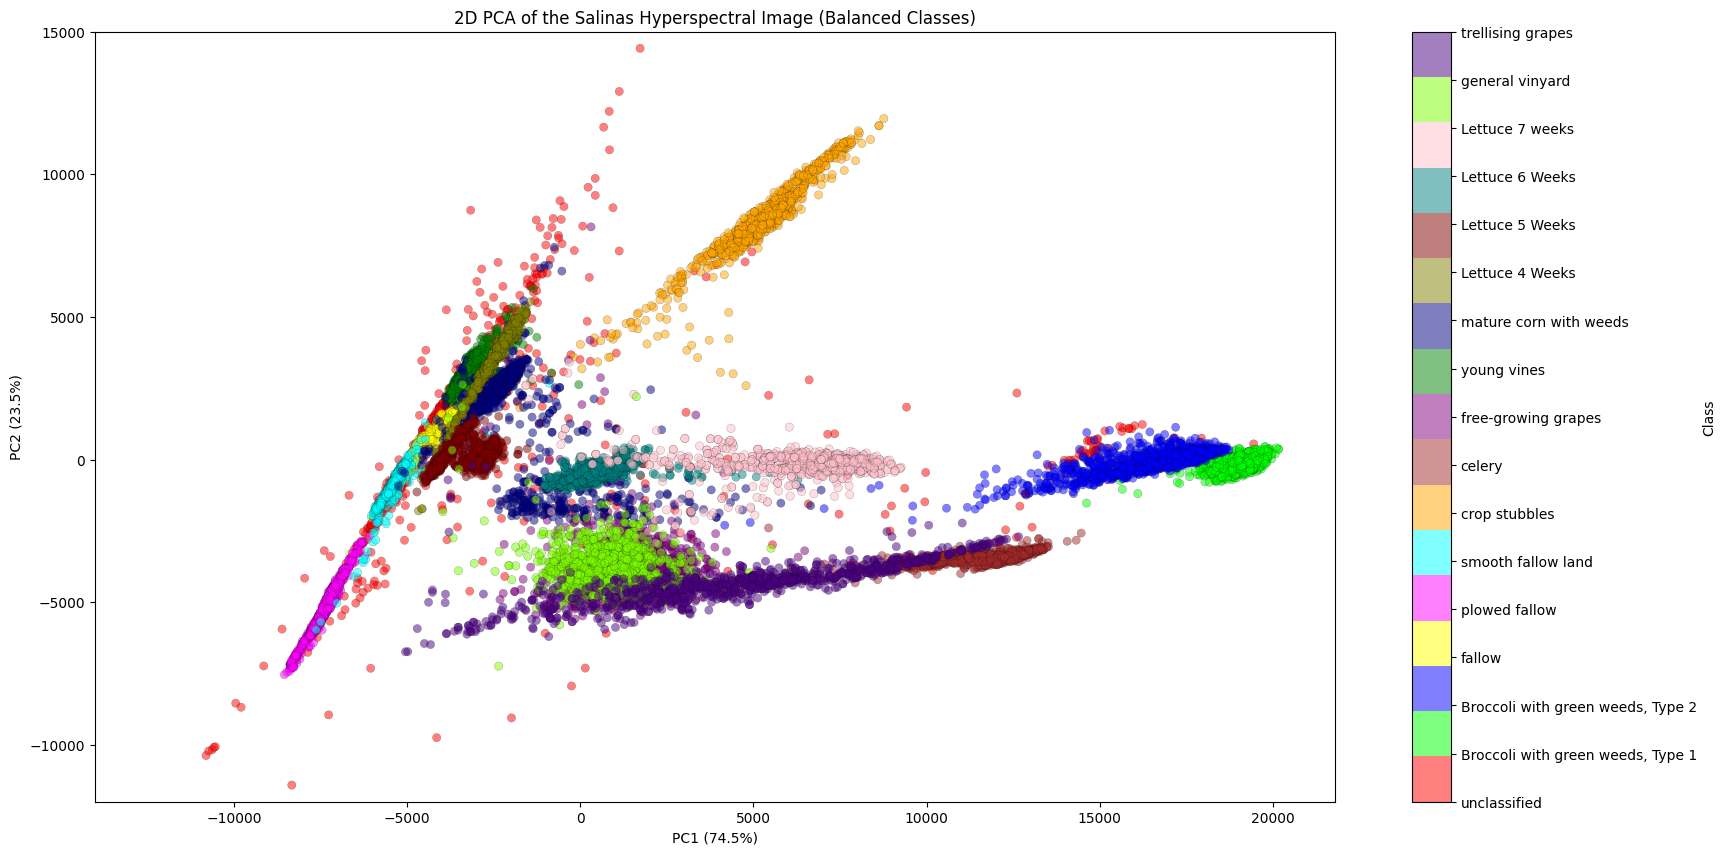

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from matplotlib.colors import ListedColormap

pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X)

rus = RandomUnderSampler()
X_vis_balanced, y_vis_balanced = rus.fit_resample(X_vis, y)

plt.figure(figsize=(20, 10))

#manual color mapping because all available cmaps made the classes difficult to distinguish visually!
manual_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00',  # Red, Green, Blue, Yellow
    '#FF00FF', '#00FFFF', '#FFA500', '#A52A2A',  # Magenta, Cyan, Orange, Brown
    '#800080', '#008000', '#000080', '#808000',  # Purple, Dark Green, Navy, Olive
    '#800000', '#008080', '#FFC0CB', '#7CFC00', '#4B0082'] # Maroon, Teal, Pink, Lawn Green, Indigo

cmap = ListedColormap(manual_colors)
classes = np.unique(y_vis_balanced)
colors = [cmap(i / len(classes)) for i in range(len(classes))]
scatter = plt.scatter(X_vis_balanced[:, 0], X_vis_balanced[:, 1], c=y_vis_balanced, cmap=cmap, alpha=0.5,
    edgecolor='k',linewidth=0.2)
cbar = plt.colorbar(scatter, ticks=classes, label='Class')
class_names = ['unclassified','Broccoli with green weeds, Type 1',
'Broccoli with green weeds, Type 2',
'fallow','plowed fallow','smooth fallow land','crop stubbles','celery','free-growing grapes',
'young vines','mature corn with weeds','Lettuce 4 Weeks','Lettuce 5 Weeks','Lettuce 6 Weeks','Lettuce 7 weeks',
'general vinyard','trellising grapes']
cbar.set_ticklabels(class_names)

plt.xlabel(f'PC1 ({round(pca_vis.explained_variance_ratio_[0] * 100, 1)}%)')
plt.ylabel(f'PC2 ({round(pca_vis.explained_variance_ratio_[1] * 100, 1)}%)')
plt.ylim((-12000, 15000)) #not plotting 2-3 unclassified outliers
plt.title('2D PCA of the Salinas Hyperspectral Image (Balanced Classes)')
plt.show()

Just the two components already capture 98% of the variance, which is an excellent performance given the original 204 features. Especially PC1 describes most of the variance. There is no class which is mostly distributed along the PC2 dimension, but several classes mostly along the PC1 dimension.
Several land cover classes form distinct clusters. Thus, the spectral signatures of these crops and land types are different enough to distinguish with a satellite, and without having to look at the actual plant. Some specific visible insights:

- the broccoli type 1 is a very tight cluster, but closely related to the broccoli type 2, which is a broader cluster.
- the grow stages of lettuce progress in the PC1 dimension, especially from week 5 to 7.
- the three classes of fallow land are all close to each other
- the mature corn is less well clustered and has two distinct areas
- the crop stubbles are relatively far off to all of the other clusters. I would have expected them closer to the fallow land!
